# Goodbye os.path: 15 Pathlib Tricks to Quickly Master The File System in Python
## No headaches and unreadable code from `os.path`
![](images/midjourney.png)

### Introduction

`os` might be the only library I've despised in Python. And given that there are over 130 thousands libraries, that's saying something. I mean, just look at this:

```python
import os

dir_path = "/home/user/documents"

files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f)) and f.endswith(".txt")]
```

It performs the simple task of finding all text files in a directory but the code is an unreadable mess. I pity the person who had to write it (ChatGPT, actually) when they could have written this in `pathlib`:

```python
from pathlib import Path

files = list(dir_path.glob("*.txt"))
```

It is almost like people at Python Software Foundation forgot that they could represent file and system paths as objects. This is ironic when virtually everything is an object in Python, even [nothing](https://docs.python.org/3/c-api/none.html). 

Thankfully they came to their senses in Python 3.4 and added `pathlib` to the standard library. Apart from introducing object-oriented file system paths, `pathlib` came with many benefits, such as highly readably code, consistency in path operations and more Pythonic API.

And this long-overdue article of mine will outline some of the best functions/features and tricks of `pathlib` to perform tasks that would have been truly horrible experiences in `os.path`.

### Working with paths

__1. Creating paths__

Almost all features of `pathlib` is accessible through its `Path` class, which you can use to create paths to files and directories. 

There are a few ways you can create paths with `Path`. First, there are class methods like `cwd` and `home` for the current working and the home user directories:

In [1]:
from pathlib import Path

Path.cwd()

PosixPath('/home/bexgboost/articles/2023/4_april/1_pathlib')

In [2]:
Path.home()

PosixPath('/home/bexgboost')

You can also create paths from string paths:

In [64]:
p = Path("documents")

p

PosixPath('documents')

Joining paths is a breeze in Pathlib with forward slash operator:

In [70]:
data_dir = Path(".") / "data"
csv_file = data_dir / "file.csv"

print(data_dir)
print(csv_file)

data
data/file.csv


Please, don't ever let anyone catch you using `os.path.join` after this. 

To check whether a path `exists`:

In [71]:
data_dir.exists()

True

In [72]:
csv_file.exists()

True

Or if a path is `is_dir` or `is_file`:

In [73]:
data_dir.is_dir()

True

In [74]:
csv_file.is_file()

True

You can also get an absolute path of a relative path when the mood fancies you:

In [75]:
csv_file.absolute()

PosixPath('/home/bexgboost/articles/2023/4_april/1_pathlib/data/file.csv')

Lastly, if you have the misfortune of working with libraries that still require string paths, you can call `str(path)`:

In [79]:
str(Path.home())

'/home/bexgboost'

> Most libraries in the data stack have long supported `Path` objects, including `sklearn`, `pandas`, `matplotlib`, `seaborn`, etc.

__2. Path attributes__

`Path` objects have many useful attributes.

In [80]:
image_file = Path(
    "images/midjourney.png"
).absolute()

image_file

PosixPath('/home/bexgboost/articles/2023/4_april/1_pathlib/images/midjourney.png')

Let's start with `parent`s:

In [81]:
image_file.parent

PosixPath('/home/bexgboost/articles/2023/4_april/1_pathlib/images')

Or for file paths, their `name`:

In [12]:
image_file.name

'midjourney.png'

which returns only the file name with the extension. 

There is also `stem` for the file name without the suffix:

In [13]:
image_file.stem

'midjourney'

Or the `suffix` itself with the dot:

In [14]:
image_file.suffix

'.png'

If you want to divide a path into its components, you can use `parts` instead of `str.split('/')`:

In [16]:
image_file.parts

('/',
 'home',
 'bexgboost',
 'articles',
 '2023',
 '4_april',
 '1_pathlib',
 'images',
 'midjourney.png')

If you want those components to be `Path` objects in themselves, you can use `parents` attribute, which creates a generator:

In [17]:
for i in image_file.parents:
    print(i)

/home/bexgboost/articles/2023/4_april/1_pathlib/images
/home/bexgboost/articles/2023/4_april/1_pathlib
/home/bexgboost/articles/2023/4_april
/home/bexgboost/articles/2023
/home/bexgboost/articles
/home/bexgboost
/home
/


### Working with files

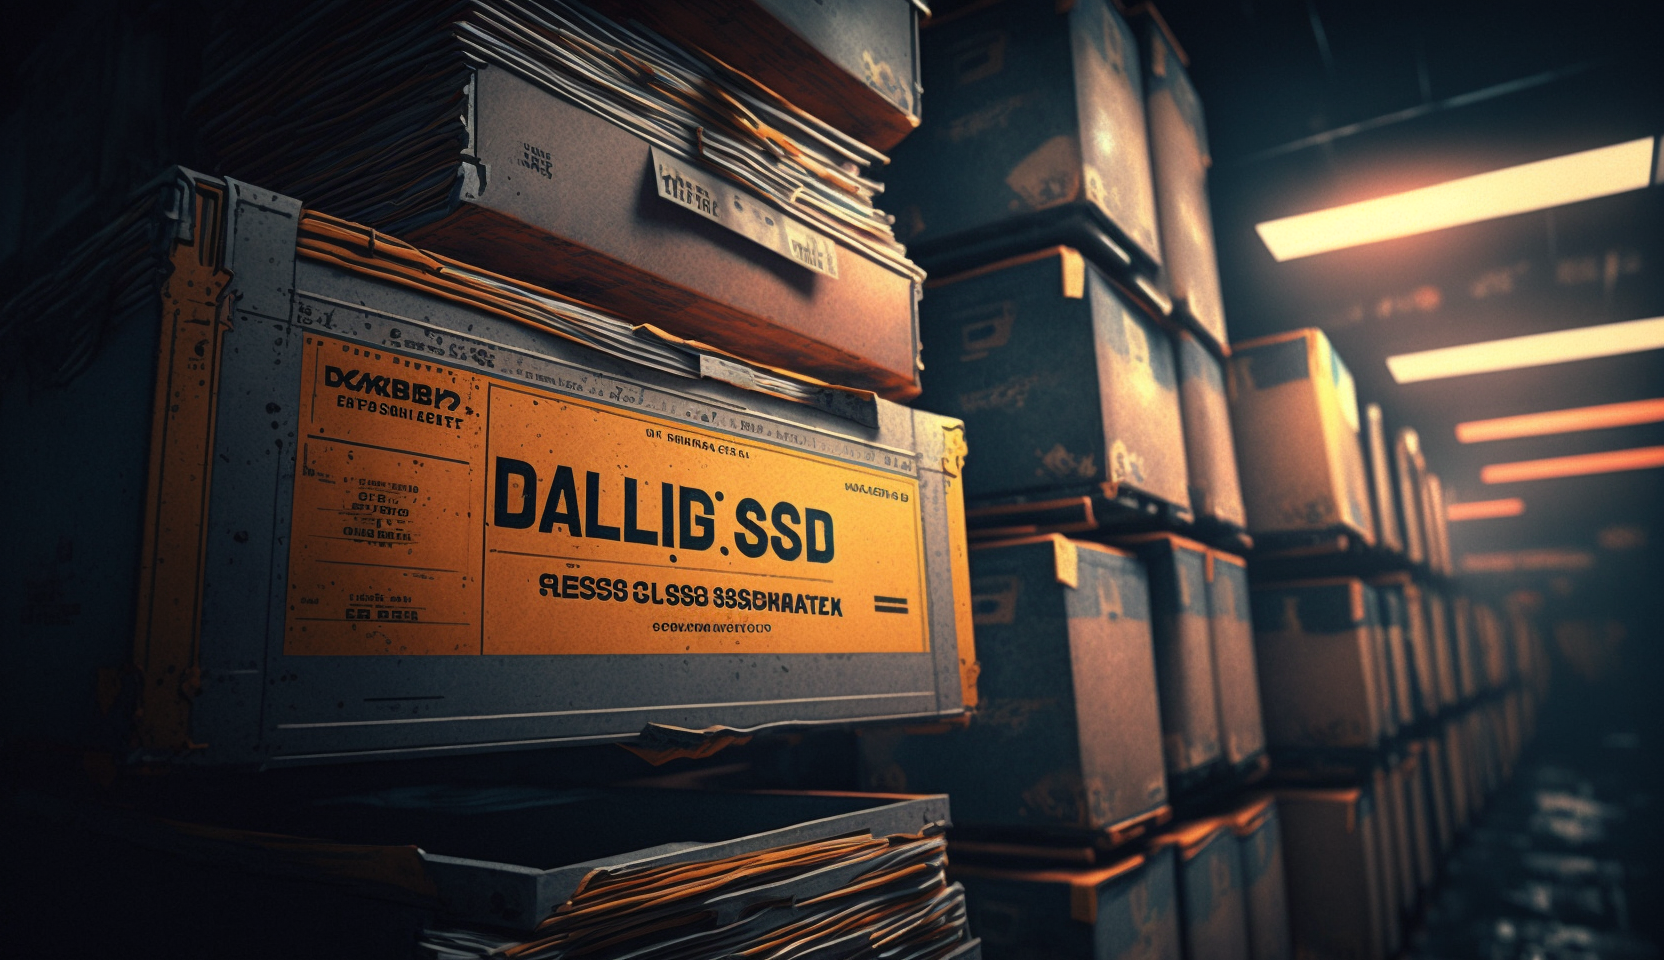

To create files and write to them, you don't have to use `open` function anymore. Just create a `Path` object and `write_text` or `write_btyes` to them:

In [87]:
markdown = data_dir / "file.md"

# Create (override) and write text
markdown.write_text("# This is a test markdown")

25

Or, if you already have a file, you can `read_text` or `read_bytes`:

In [88]:
markdown.read_text()

'# This is a test markdown'

In [89]:
len(image_file.read_bytes())

1962148

However, note that `write_text` or `write_bytes` overrides existing contents of a file.

In [90]:
# Write new text to existing file
markdown.write_text("## This is a new line")

21

In [91]:
# The file is overridden
markdown.read_text()

'## This is a new line'

To append new information to existing files, you can use `open` method of `Path` objects in `a` (append) mode:

In [92]:
# Append text
with markdown.open(mode="a") as file:
    file.write("\n### This is the second line")

markdown.read_text()

'## This is a new line\n### This is the second line'

It is also common to rename files. `rename` method accepts the source file path and the destination path for the renamed file.

To create the destination path in the current directory, i. e. rename the file, you can use `with_stem` on the existing path, which replaces the `stem` of the original file:

In [93]:
renamed_md = markdown.with_stem("new_markdown")

markdown.rename(renamed_md)

PosixPath('data/new_markdown.md')

Above, `file.md` is turned into `new_markdown.md`.

Let's see its `st_size`:

In [99]:
# Display file size
renamed_md.stat().st_size

49

It is 49 bytes. Let's see the last time it was modified, which was a few seconds ago:

In [33]:
from datetime import datetime

modified_timestamp = renamed_md.stat().st_mtime

datetime.fromtimestamp(modified_timestamp)

datetime.datetime(2023, 4, 3, 13, 32, 45, 542693)

`st_mtime` returns a timestamp, which is the count of seconds since January 1, 1970. To make it readable, you can use use the `fromtimestamp` function of `datatime`.

To remove unwanted files, you can `unlink` them:

In [35]:
renamed_md.unlink(missing_ok=True)

Setting `missing_ok` to `True` won't raise any alarms if the file doesn't exist.

### Working with directories

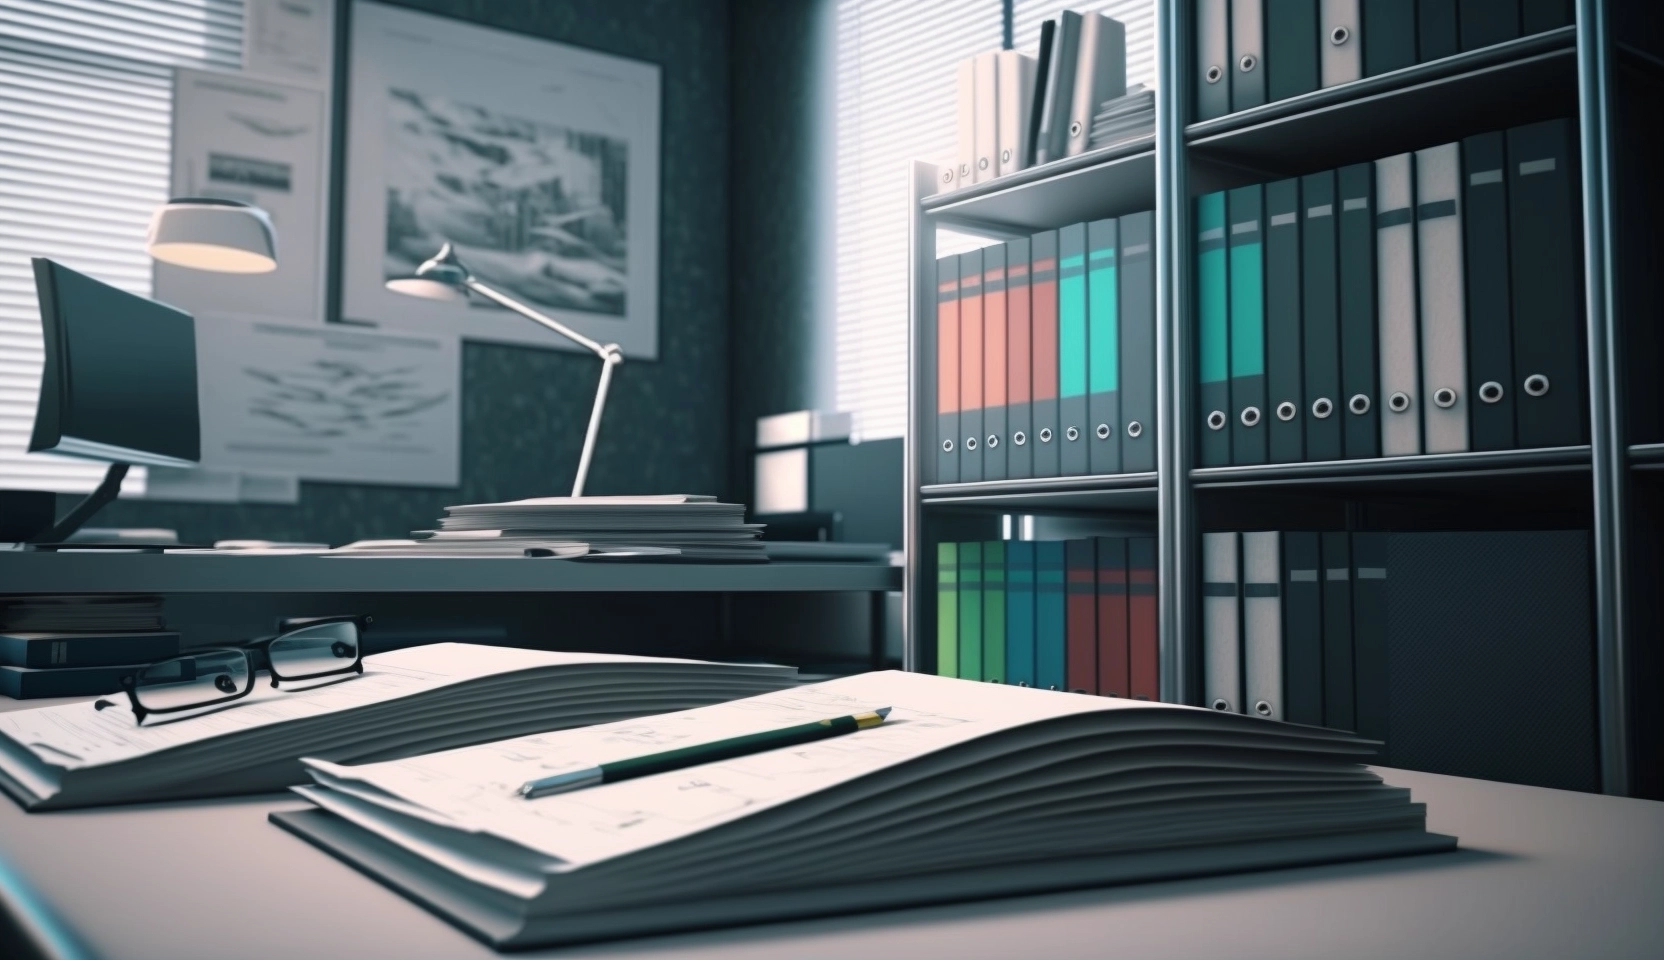

There are a few neat tricks to work with directories in Pathlib. First, let's see how to create directories recursively.

In [37]:
new_dir = (
    Path.cwd()
    / "new_dir"
    / "child_dir"
    / "grandchild_dir"
)

new_dir.exists()

False

The `new_dir` doesn't exist, so, let's create it with its children:

In [39]:
new_dir.mkdir(parents=True, exist_ok=True)

By default, `mkdir` creates the last child of the given path. If the intermediate parents don't exist, you have to set `parents` to `True`.

To remove empty directories, you can use `rmdir`. If the given path object is nested, only the last child directory is deleted:

In [ ]:
# Removes the last child directory
new_dir.rmdir()

To list the contents of a directory like `ls` on the terminal, you can use `iterdir`. Again, the result will be a generator object, yielding directory contents as separate path objects one at a time:

```python
for p in Path.home().iterdir():
    print(p) 
```

```
/home/bexgboost/.python_history
/home/bexgboost/word_counter.py
/home/bexgboost/.azure
/home/bexgboost/.npm
/home/bexgboost/.nv
/home/bexgboost/.julia
...
```

To capture all files with a certain extension or a name pattern, you use the `glob` function with a regular expression. 

For example, below, we will find all text files inside my home directory with `glob("*.txt")`:

```python
home = Path.home()
text_files = list(home.glob("*.txt"))

len(text_files)
```

```
3
```

There are only three. To search for text files recursively, meaning all children directories as well, you can use _recursive glob_ with `rglob`:

In [48]:
all_text_files = [p for p in home.rglob("*.txt")]

len(all_text_files)

5116

> Learn about regular expressions [here](https://realpython.com/regex-python/).

You can also use `rglob('*')` to recursively list directory contents. It is like the supercharged version of `iterdir()`. 

One of the use cases of this is counting the number of file formats that appear within a directory.

To do this, we import the `Counter` class from `collections` and provide all files suffixes to it within the articles folder of `home`:

```python
from collections import Counter

file_counts = Counter(
    path.suffix for path in (home / "articles").rglob("*")
)

file_counts
```

```
Counter({'.py': 12,
         '': 1293,
         '.md': 1,
         '.txt': 7,
         '.ipynb': 222,
         '.png': 90,
         '.mp4': 39})
```

### Operating system differences

Sorry, but we have to talk about this nightmare of an issue.

Up until now, we have been dealing with `PosixPath` objects, which are the default for UNIX-like systems:

In [100]:
type(Path.home())

pathlib.PosixPath

If you were on Windows, you would get a `WindowsPath` object:

```python
from pathlib import WindowsPath

# User raw strings that start with r to write windows paths
path = WindowsPath(r"C:\users")
path
```

```python
NotImplementedError: cannot instantiate 'WindowsPath' on your system
```

Instantiating another system's path raises an error like above. 

But what if were forced to work with paths from other system, like code written by coworkers who use Windows?

As a solution, `pathlib` offers pure path objects like `PureWindowsPath` or `PurePosixPath`:

In [104]:
from pathlib import PurePosixPath, PureWindowsPath

path = PureWindowsPath(r"C:\users")
path

PureWindowsPath('C:/users')

These are primitive path objects. You've access to some path methods and attributes but essentially, the path object remains a string:

In [105]:
path / "bexgboost"

PureWindowsPath('C:/users/bexgboost')

In [110]:
path.parent

PureWindowsPath('C:/')

In [108]:
path.stem

'users'

```python
path.rename(r"C:\losers")
```

```
AttributeError: 'PureWindowsPath' object has no attribute 'rename'
```

### Conclusion

If you have noticed, I lied in the title of the article. Instead of 15, I believe the count of the new tricks and functions was 30ish. I didn't want to scare you off. 

But I hope that I've convinced you enough to ditch `os.path` and start using `pathlib` for your own sake. 

Forge a new path, if you will :)

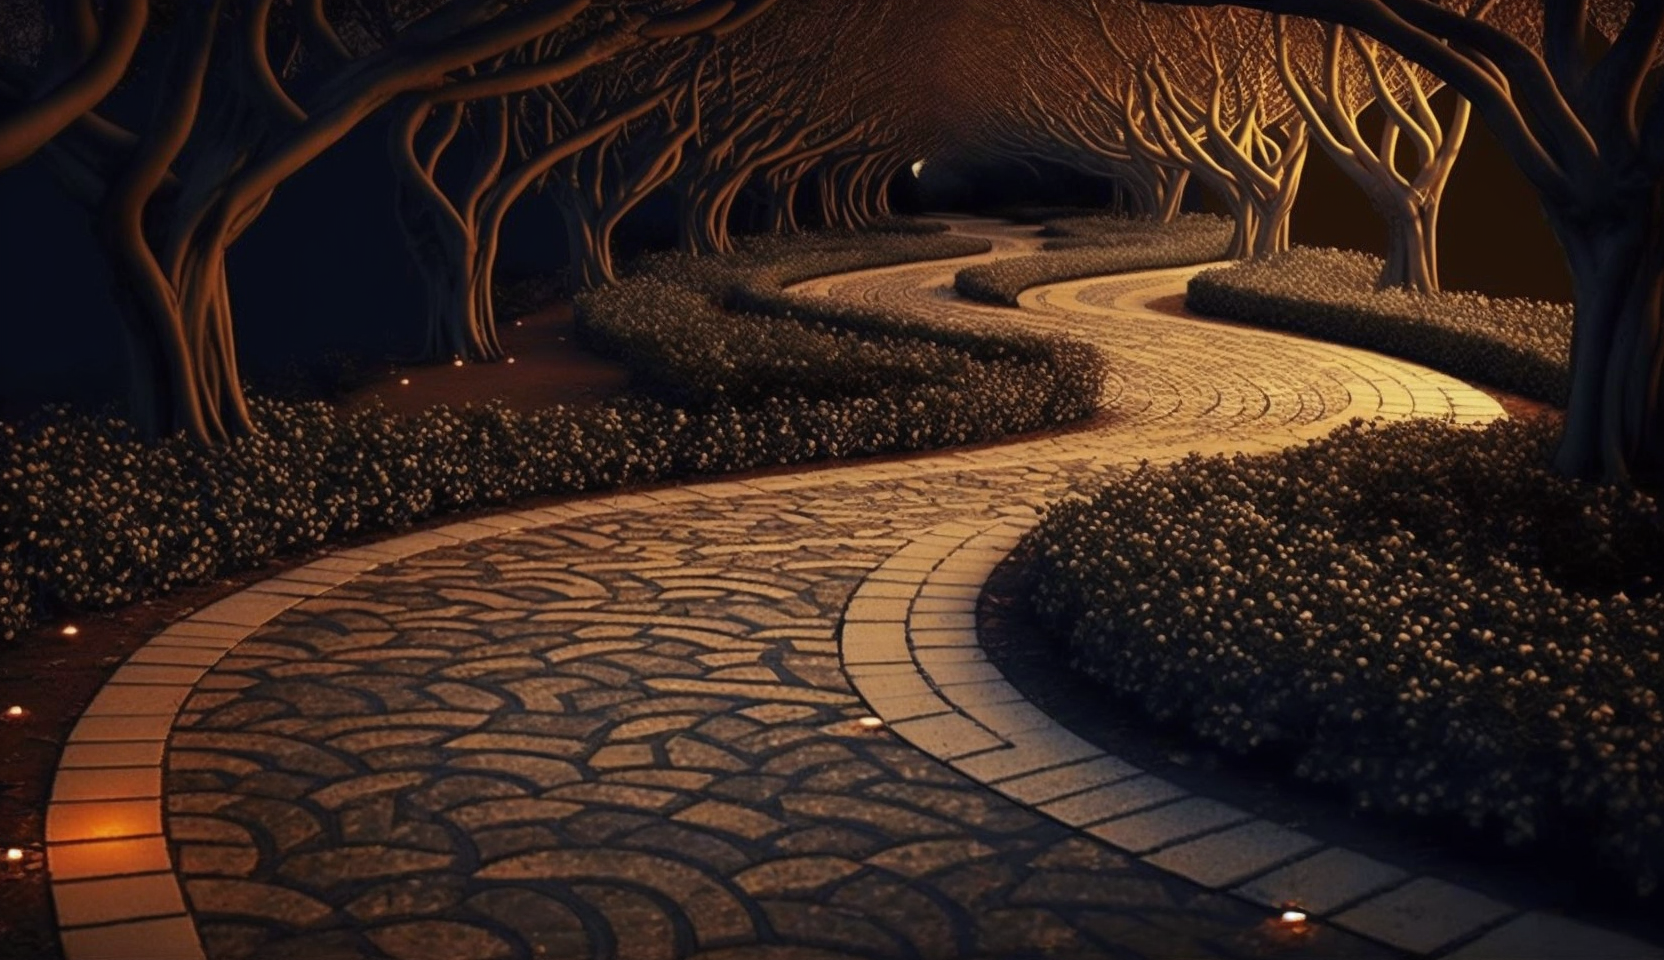